<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Imbalanced_Learning/Example_Imbalanced_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U imbalanced-learn

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [3]:
data = fetch_openml(data_id=1220)

df = pd.DataFrame(data['data'], columns=data['feature_names']).astype(float)
df['target'] = pd.Series(data['target'].astype(int))
df.sample(n=5, random_state=42)

,impression,ad_id,advertiser_id,depth,position,keyword_id,title_id,description_id,user_id,target
12831,1.0,20884487.0,22234.0,1.0,1.0,19303.0,83270.0,74248.0,70.0,0
34147,29.0,10593104.0,1268.0,2.0,1.0,3275.0,2136.0,128.0,0.0,1
7656,1.0,21319021.0,20551.0,2.0,2.0,4766.0,15510.0,15125.0,11569401.0,0
8659,1.0,3831882.0,27486.0,2.0,1.0,1007.0,2869.0,387.0,12581245.0,0
17460,1.0,21442048.0,37039.0,3.0,1.0,35349.0,399482.0,328000.0,0.0,0


In [8]:
print('{:.3f}'.format(df['target'].mean()))

0.168


In [7]:
# check cardinality of each feature
for feature in data['feature_names']:
  print('Cardinality of {}: {:,}'.format(
      feature, df[feature].value_counts().shape[0]
  ))

# create training and testing samples
x, y = df[data['feature_names']], df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Cardinality of impression: 99
Cardinality of ad_id: 19,228
Cardinality of advertiser_id: 6,064
Cardinality of depth: 3
Cardinality of position: 3
Cardinality of keyword_id: 19,803
Cardinality of title_id: 25,321
Cardinality of description_id: 22,381
Cardinality of user_id: 30,114


In [4]:
def predict_and_evaluate(x_train, y_train, x_test, y_test, sample_weight=None, title='Unweighted'):
  clf = Pipeline(
      [
       ('Embedder', RandomTreesEmbedding(n_estimators=10, max_leaf_nodes=20, random_state=42)),
       ('Scaler', MaxAbsScaler()),
       ('Classifier', LogisticRegression(solver='saga', max_iter=1000, random_state=42))
      ]
  )
  clf.fit(x_train, y_train, Classifier__sample_weight=sample_weight)
  y_test_pred = clf.predict(x_test)
  print(
      'Precision: {:.02%}, Recall: {:.02%}; G-mean: {:.02%} @ {}'.format(
          precision_score(y_test, y_test_pred),
          recall_score(y_test, y_test_pred),
          geometric_mean_score(y_test, y_test_pred),
          title
      )
  )
  return clf

In [11]:
clf = predict_and_evaluate(x_train, y_train, x_test, y_test)

Precision: 62.50%, Recall: 0.30%; G-mean: 5.45% @ Unweighted


In [12]:
# Applying sample weights. The number of samples in the majority class is about
# five times that of the minority class. So apply sampwt of 5 to the minority samples.
sample_weight = (1*(y_train == 0)) + (5*(y_train==1))
clf = predict_and_evaluate(x_train, y_train, x_test, y_test, 
                           sample_weight=sample_weight, title="Weighted")

Precision: 24.78%, Recall: 13.38%; G-mean: 35.04% @ Weighted


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [5]:
def calculate_feature_coeff(clf):
  return pd.DataFrame(
      {
          'Features': [
                       f'EmbFeature{e}' for e in range(len(clf[-1].coef_[0]))
          ] + ['Intercept'],
          'Coeff': list(clf[-1].coef_[0]) + [clf[-1].intercept_[0]]
      }
  ).set_index('Features').tail(10)

In [14]:
calculate_feature_coeff(clf)

,Coeff
Features,
EmbFeature187,0.442264
EmbFeature188,-1.540624
EmbFeature189,-0.427968
EmbFeature190,0.596631
EmbFeature191,0.514360
EmbFeature192,0.866120
EmbFeature193,-0.925437
EmbFeature194,-0.150263
EmbFeature195,-0.294957


In [8]:
# Compare three weighting strategies
df_coef_list = []
weight_options = [1,2,5]

for w in weight_options:
  print(f'\nMinority Class (Positive Class) Weight = Weight x {w}')
  sample_weight = (1*(y_train == 0)) + (w*(y_train == 1))
  clf = predict_and_evaluate(x_train, y_train, x_test, y_test, sample_weight=sample_weight, title='Unbalanced')
  df_coef = calculate_feature_coeff(clf)
  df_coef = df_coef.rename(columns={'Coeff': f'Coeff [w={w}]'})
  df_coef_list.append(df_coef)

pd.concat(df_coef_list, axis=1).round(2).style.bar(
    subset=[f'Coeff [w={w}]' for w in weight_options],
    color='#999', align='zero'
)


Minority Class (Positive Class) Weight = Weight x 1
Precision: 62.50%, Recall: 0.30%; G-mean: 5.45% @ Unbalanced

Minority Class (Positive Class) Weight = Weight x 2
Precision: 36.36%, Recall: 2.14%; G-mean: 14.57% @ Unbalanced

Minority Class (Positive Class) Weight = Weight x 5
Precision: 24.78%, Recall: 13.38%; G-mean: 35.04% @ Unbalanced


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,Coeff [w=1],Coeff [w=2],Coeff [w=5]
Features,,,
EmbFeature187,0.090000,0.170000,0.440000
EmbFeature188,-1.180000,-1.370000,-1.540000
EmbFeature189,-0.170000,-0.260000,-0.430000
EmbFeature190,0.370000,0.450000,0.600000
EmbFeature191,0.370000,0.440000,0.510000
EmbFeature192,0.600000,0.760000,0.870000
EmbFeature193,-0.920000,-0.880000,-0.930000
EmbFeature194,-0.240000,-0.200000,-0.150000
EmbFeature195,-0.130000,-0.180000,-0.290000


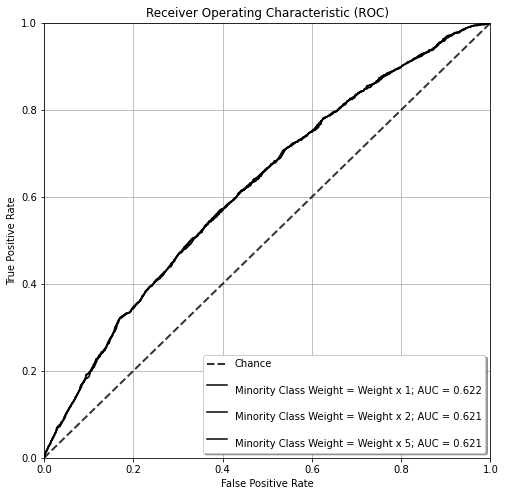

In [9]:
# Compare ROC curves
def plot_roc_curve(y, y_proba, ax, label):
  fpr, tpr, thr = roc_curve(y, y_proba)
  auc_value = auc(fpr, tpr)
  pd.DataFrame(
      {'FPR': fpr, 'TPR': tpr}
  ).set_index('FPR')['TPR'].plot(label=label+f'; AUC = {auc_value:.3f}',
                                 kind='line', xlim=(0,1), ylim=(0,1),
                                 color='k', ax=ax)
  return (fpr, tpr, auc_value)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(
    [0,1], [0,1], linestyle='--', lw=2, color='k', label='Chance', alpha=0.8
)

for w in weight_options:
  sample_weight = (1*(y_train == 0)) + (w*(y_train == 1))
  clf = Pipeline([
                  ('Embedder', RandomTreesEmbedding(n_estimators=20, max_leaf_nodes=20, random_state=42)),
                  ('Scaler', MaxAbsScaler()),
                  ('Classifier', LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42))
  ])
  clf.fit(x_train, y_train, Classifier__sample_weight=sample_weight)
  y_test_pred_proba = clf.predict_proba(x_test)[:,1]
  plot_roc_curve(y_test, y_test_pred_proba, label=f'\nMinority Class Weight = Weight x {w}', ax=ax)
  
ax.set_title('Receiver Operating Characteristic (ROC)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(ncol=1,shadow=True)
ax.grid()
fig.show()

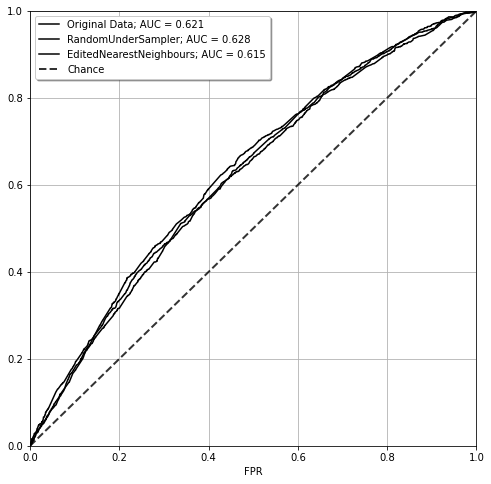

In [10]:
# Undersampling the majority class
# rus = RandomUnderSampler(sampling_strategy=0.5)
# x_train_resampled, y_train_resampled = rus.fit_sample(x_train, y_train)

# enn = EditedNearestNeighbours(n_neighbors=5)
# x_train_resampled, y_train_resampled = enn.fit_resample(x_train, y_train)

def sample_and_predict(x_train, y_train, x_test, y_test, sampler=None):
  if sampler:
    x_train, y_train = sampler.fit_resample(x_train, y_train)
  clf = Pipeline(
      [
       ('Embedder', RandomTreesEmbedding(n_estimators=10, max_leaf_nodes=20, random_state=42)),
       ('Scaler', MaxAbsScaler()),
       ('Classifier', LogisticRegression(solver='saga', max_iter=1000, random_state=42))
      ]
  )
  clf.fit(x_train, y_train)
  y_test_pred_proba = clf.predict_proba(x_test)[:,1]
  return y_test, y_test_pred_proba

fig, ax = plt.subplots(1,1,figsize=(8,8))

# Original Data
y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=None)
plot_roc_curve(
    y_test, y_test_pred_proba, label='Original Data', ax=ax
)

# RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=rus)
plot_roc_curve(y_test, y_test_pred_proba, label='RandomUnderSampler', ax=ax)

# EditedNearestNeighbours
nc = EditedNearestNeighbours(n_neighbors=5)
y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=nc)
plot_roc_curve(y_test, y_test_pred_proba, label='EditedNearestNeighbours', ax=ax)

ax.plot(
    [0,1], [0,1], linestyle='--', lw=2, color='k', label='Chance', alpha=0.8
)
ax.legend(ncol=1, shadow=True)
ax.grid()
fig.show()

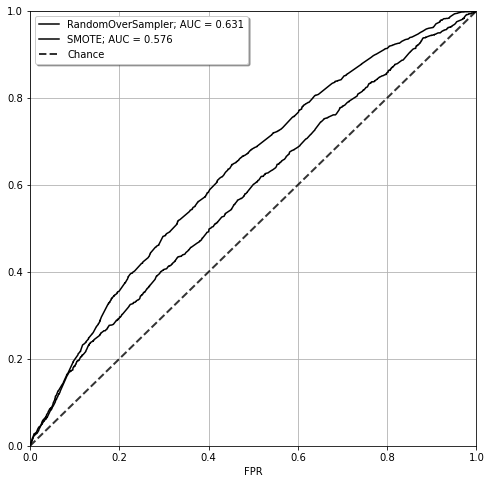

In [14]:
# Oversampling the minority class
fig, ax = plt.subplots(1,1,figsize=(8,8))

# RandomOverSampler
ros = RandomOverSampler(random_state=42)
y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=ros)
plot_roc_curve(y_test, y_test_pred_proba, label='RandomOverSampler', ax=ax)

# SMOTE
smote = SMOTE(random_state=42)
y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=smote)
plot_roc_curve(y_test, y_test_pred_proba, label='SMOTE', ax=ax)

ax.plot(
    [0,1], [0,1], linestyle='--', lw=2, color='k', label='Chance', alpha=0.8
)
ax.legend(shadow=True)
ax.grid()
fig.show()

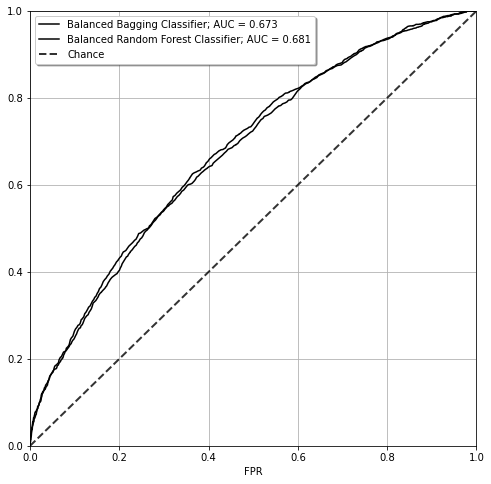

In [16]:
# Combining data sampling with ensembles
fig, ax = plt.subplots(1,1,figsize=(8,8))

# BalancedBaggingClassifier
clf = BalancedBaggingClassifier(n_estimators=500, n_jobs=-1, random_state=42)
clf.fit(x_train, y_train)
y_test_pred_proba = clf.predict_proba(x_test)[:,1]

plot_roc_curve(y_test, y_test_pred_proba, label='Balanced Bagging Classifier', ax=ax)

# BalancedRandomForestClassifer
clf = BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
clf.fit(x_train, y_train)
y_test_pred_proba = clf.predict_proba(x_test)[:,1]

plot_roc_curve(y_test, y_test_pred_proba, label='Balanced Random Forest Classifier', ax=ax)

ax.plot(
    [0,1], [0,1], linestyle='--', lw=2, color='k', label='Chance', alpha=0.8
)
ax.legend(shadow=True)
ax.grid()
fig.show()

In [19]:
# Equal opportunity score
def equal_opportunity_score(df, true_label, predicted_label, feature_name, feature_value):
  opportunity_to_value = df[(df[true_label]==1) & (df[feature_name] == feature_value)
  ][predicted_label].mean()/df[(df[true_label]==1) & (df[feature_name] != feature_value)][predicted_label].mean()
  opportunity_to_other_values = 1 / opportunity_to_value
  better_opportunity_to_value = opportunity_to_value > opportunity_to_other_values
  return {
  'Score': min(opportunity_to_value, opportunity_to_other_values),
  f'Better Opportunity to {feature_value}': better_opportunity_to_value
}

In [20]:
df_engineers = pd.DataFrame(
{
  'IQ':     [110, 120, 124, 123, 112, 114],
  'Gender': ['M', 'F', 'M', 'F', 'M', 'F'],
  'Is Hired? (True Label)': [0, 1, 1, 1, 1, 0],
  'Is Hired? (Predicted Label)': [1, 0, 1, 1, 1, 0],
}
)

equal_opportunity_score(df=df_engineers, true_label='Is Hired? (True Label)',
                        predicted_label='Is Hired? (Predicted Label)',
                        feature_name='Gender', feature_value='F')


{'Better Opportunity to F': False, 'Score': 0.5}